<a href="https://colab.research.google.com/github/natzasu13/microexpresion-recognition/blob/smic-microexpresion/Microexpression_recognition_MicroExpSTCNN_SMIC_Maestria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Microexpresion recognition**
#**SMIC Database**



**MicroExpSTCNN Model**

Natalia Zartha
Maestria en Ingenira de Sistemas y Computación, 2021

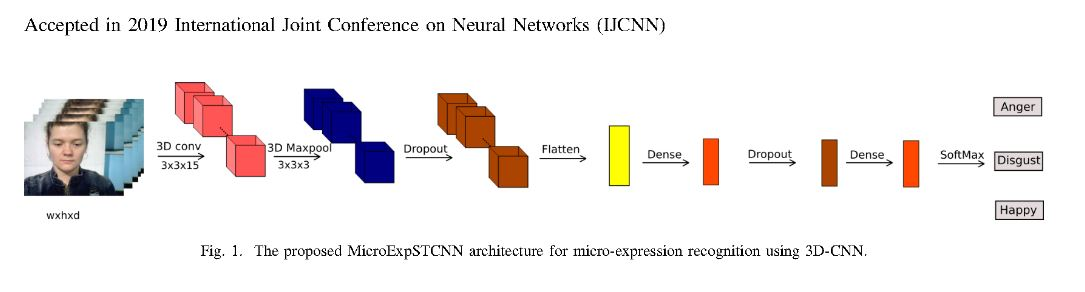

In [1]:
import os
import cv2
import numpy
import imageio
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.optimizers import SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, generic_utils
from sklearn.model_selection import train_test_split
from keras import backend as K
import sys
from matplotlib import pyplot as plt


#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')

#Import files from google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#SMIC

#Load images

In [3]:
image_rows, image_columns, image_depth = 64, 64, 18

training_list = []

CODE_PATH = 'drive/MyDrive/MAESTRIA ING DE SISTEMAS/1. MICROEXPRESIONES FACIALES TRABAJO DE GRADO/3. Codigo/microexpresion-recognition-colab/SMIC'
SMIC_path = CODE_PATH + '/datasets/SMIC'

HSpath =SMIC_path +'/SMIC_all_cropped/HS/'

print("-------------------------negativepath----------------------")  

rootDirectory = os.listdir(HSpath)
for s in rootDirectory:
    sPath = HSpath + s + "/micro/negative/"
    microPath = os.listdir(sPath)
    for video in microPath:
        videopath = sPath + video

        frames = []
        framelisting = os.listdir(videopath)
        framesCount = image_depth if len(framelisting) > image_depth else 0
     
        print("framesCount")
        print(framesCount)

        framerange = [x for x in range(18)]

        if(framesCount != 0):
            for frame in framerange:
                  imagepath = videopath + "/" + framelisting[frame]

                  image = cv2.imread(imagepath)
                  imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
                  grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
                  frames.append(grayimage)

            frames = numpy.asarray(frames)
            videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
            
            training_list.append(videoarray)
            print(len(training_list))


    print("-------------------------positivepath----------------------")  

    sPath = HSpath + s + "/micro/positive/"
    microPath = os.listdir(sPath)
    for video in microPath:
        videopath = sPath + video
        frames = []
        framelisting = os.listdir(videopath)
        framesCount = image_depth if len(framelisting) > image_depth else 0

        framerange = [x for x in range(18)]

        print("framesCount")
        print(framesCount)

        if(framesCount != 0):
            for frame in framerange:
                  imagepath = videopath + "/" + framelisting[frame]
                  image = cv2.imread(imagepath)
                  imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
                  grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
                  frames.append(grayimage)

            frames = numpy.asarray(frames)
            videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
            
            training_list.append(videoarray)
            print(len(training_list))


    print("-------------------------surprise----------------------")  

    sPath = HSpath + s + "/micro/surprise/"
    microPath = os.listdir(sPath)
    for video in microPath:
        videopath = sPath + video
        frames = []
        framelisting = os.listdir(videopath)
        framesCount = image_depth if len(framelisting) > image_depth else 0

        framerange = [x for x in range(18)]

        print("framesCount")
        print(framesCount)

        if(framesCount != 0):
            for frame in framerange:
                  imagepath = videopath + "/" + framelisting[frame]
                  image = cv2.imread(imagepath)
                  imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
                  grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
                  frames.append(grayimage)

            frames = numpy.asarray(frames)
            videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
            
            training_list.append(videoarray)
            print(len(training_list))









-------------------------negativepath----------------------
framesCount
18
1
framesCount
18
2
framesCount
18
3
-------------------------positivepath----------------------
framesCount
18
4
framesCount
18
5
framesCount
18
6
-------------------------surprise----------------------
framesCount
18
7
framesCount
18
8
framesCount
18
9
-------------------------positivepath----------------------
-------------------------surprise----------------------
framesCount
18
10
framesCount
18
11
framesCount
18
12
framesCount
18
13
framesCount
18
14
-------------------------positivepath----------------------
framesCount
18
15
-------------------------surprise----------------------
framesCount
18
16
framesCount
18
17
framesCount
18
18
framesCount
18
19
framesCount
18
20
framesCount
18
21
-------------------------positivepath----------------------
framesCount
18
22
-------------------------surprise----------------------
framesCount
18
23
framesCount
18
24
framesCount
18
25
framesCount
18
26
framesCount
18
27

#Training

In [4]:
#164 imagenes que se conviernes en escala de gris
#64x64 tamaño
#18 frames 


training_list = numpy.asarray(training_list)
trainingsamples = len(training_list)

print("trainingsamples")
print(trainingsamples)

traininglabels = numpy.zeros((trainingsamples, ), dtype = int)

traininglabels[0:66] = 0
traininglabels[66:113] = 1
traininglabels[113:156] = 2

traininglabels = np_utils.to_categorical(traininglabels, 3)

training_data = [training_list, traininglabels]
(trainingframes, traininglabels) = (training_data[0], training_data[1])

training_set = numpy.zeros((trainingsamples, 1, image_rows, image_columns, image_depth))

print("range(trainingsamples) is the value of h")
print(range(trainingsamples))

for h in range(trainingsamples):
    training_set[h][0][:][:][:] = trainingframes[h, :, :, :]


training_set = training_set.astype('float32')
training_set -= numpy.mean(training_set)
training_set /= numpy.max(training_set)

print("training_set.shape")
print(training_set.shape)

# Save training images and labels in a numpy array
numpy.save(CODE_PATH+'/numpy_training_datasets/microexpstcnn_images.npy', training_set)
numpy.save(CODE_PATH+'/numpy_training_datasets/microexpstcnn_labels.npy', traininglabels)

# Load training images and labels that are stored in numpy array
"""
training_set = numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_images.npy')
traininglabels =numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_labels.npy')
"""

trainingsamples
159
range(trainingsamples) is the value of h
range(0, 159)
training_set.shape
(159, 1, 64, 64, 18)


"\ntraining_set = numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_images.npy')\ntraininglabels =numpy.load(CODE_PATH+'/numpy_training_datasets/microexpstcnn_labels.npy')\n"

#Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 42, 62, 62, 4)     5712      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 42, 20, 20, 1)     0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 20, 20, 1)     0         
_________________________________________________________________
flatten (Flatten)            (None, 16800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2150528   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

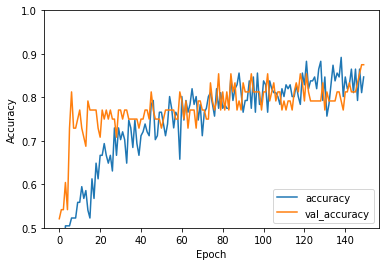

In [5]:
# MicroExpSTCNN Model
model = Sequential()
model.add(Convolution3D(42, (3, 3, 15), input_shape=(1, image_rows, image_columns, image_depth), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(Dense(128, init='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(3, init='normal'))
model.add(Dense(3, kernel_initializer='normal'))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

model.summary()

filepath=CODE_PATH+"/weights_microexpstcnn/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
######filepath=CODE_PATH+"/weights_microexpstcnn/model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Load pre-trained weights
#model.load_weights(CODE_PATH+'/weights_microexpstcnn/weights-improvement-40-0.69.hdf5')
#model.load_weights(CODE_PATH+'/weights_microexpstcnn/weights-improvement-01-1.00.hdf5')

# Spliting the dataset into training and validation setsl
train_images, validation_images, train_labels, validation_labels =  train_test_split(training_set, traininglabels, test_size=0.3, random_state=4)

# Save validation set in a numpy array
numpy.save(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_images.npy', validation_images)
numpy.save(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_labels.npy', validation_labels)

# Load validation set from numpy array
#validation_images = numpy.load(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_images.npy')
#validation_labels = numpy.load(CODE_PATH+'/numpy_validation_dataset/microexpstcnn_val_labels.npy')


# Training the model
#hist = model.fit(train_images, train_labels, validation_data = (validation_images, validation_labels), callbacks=callbacks_list, batch_size = 16, nb_epoch = 100, shuffle=True)
hist = model.fit(train_images, train_labels, validation_data = (validation_images, validation_labels), callbacks=callbacks_list, batch_size = 16, epochs = 150, shuffle=True)


plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print("----------Evaluando el modelo --------")
test_loss, test_acc = model.evaluate(validation_images,  validation_labels, verbose=2)
print("test_acc")
print(test_acc)

#Predictions


In [11]:

# Finding Confusion Matrix using pretrained weights

print("------------------validation_images--------------------")
print(validation_images.shape)
print(validation_images)
print("------------------validation_labels--------------------")
print(validation_labels.shape)
print(validation_labels)



predictions = model.predict(validation_images)
predictions_labels = numpy.argmax(predictions, axis=1)


print("-------------------predictions------------------------")
print(predictions)
print("-------------------predictions_labels-----------------")
print(predictions_labels.shape)
print(predictions_labels)

validation_labels_y = numpy.argmax(validation_labels, axis=1)



print("-------------------validation_labels_new---------------")
print(validation_labels_y.shape)
print(validation_labels_y)


print("-------------------Prediction labels---------------")
print(predictions_labels)

cfm = confusion_matrix(validation_labels_y, predictions_labels)
print("------------------------------confusion_matrix------------------------------")
print (cfm)

print('Accuracy score :', accuracy_score(validation_labels_y,predictions_labels) )


print('Classification report :', classification_report(validation_labels_y,predictions_labels) )


#precision, recall, thresholds = precision_recall_curve(validation_labels_y,predictions_labels)


------------------validation_images--------------------
(48, 1, 64, 64, 18)
[[[[[-0.03338297 -0.03942615 -0.03338297 ... -0.06359885 -0.0756852
     -0.06359885]
    [-0.1240306  -0.1240306  -0.1240306  ... -0.15424648 -0.16028966
     -0.16028966]
    [-0.172376   -0.18446235 -0.17841919 ... -0.1965487  -0.1965487
     -0.20259188]
    ...
    [-0.20259188 -0.20863506 -0.20863506 ... -0.21467823 -0.22072141
     -0.21467823]
    [-0.25093728 -0.25093728 -0.2448941  ... -0.26302364 -0.26302364
     -0.26302364]
    [-0.30532587 -0.2992827  -0.2992827  ... -0.30532587 -0.30532587
     -0.30532587]]

   [[-0.00921027 -0.01525345 -0.0031671  ... -0.03338297 -0.03942615
     -0.03338297]
    [-0.11194425 -0.11798743 -0.10590108 ... -0.15424648 -0.16028966
     -0.16028966]
    [-0.10590108 -0.0998579  -0.09381472 ... -0.1240306  -0.13611695
     -0.11798743]
    ...
    [-0.1965487  -0.1965487  -0.20259188 ... -0.20863506 -0.21467823
     -0.20259188]
    [-0.25093728 -0.25093728 -0.250937

In [12]:
train_images.shape


(111, 1, 64, 64, 18)

In [13]:
validation_images.shape

(48, 1, 64, 64, 18)

#Save model as json string

In [15]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

#Detecting false expressions




In [10]:

import cv2
import numpy as np

with open(CODE_PATH + "/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights(CODE_PATH+"/weights_microexpstcnn/weights-improvement-128-0.88.hdf5")
#loaded_model._make_predict_function()

##Agregar archivo haarcascade_frontalface_default en esta ruta de trabajo
facec = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_default.xml")
font = cv2.FONT_HERSHEY_SIMPLEX
EMOTIONS_LIST=["Negative", "Positive", "Surprise"]


video = cv2.VideoCapture(CODE_PATH+"/false_expresions/presidential_debate.mp4")

_, fr = video.read()
gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
faces = facec.detectMultiScale(gray_fr, 1.3, 5)

print("faces")
print(faces)


for (x, y, w, h) in faces:
    fc = gray_fr[y:y+h, x:x+w]

    roi = cv2.resize(fc, (48, 48))
    pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])

    emotion= EMOTIONS_LIST[np.argmax(pred)]
    print("pred")
    print(pred)
    
    print("emotion")
    print(emotion)

    cv2.putText(fr, emotion, (x, y), font, 1, (255, 255, 0), 2)
    cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

_, jpeg = cv2.imencode('.jpg', fr)

ValueError: ignored